# **Imports**

In [1]:
# importing required libraries
import numpy as np
import pandas as pd
import pickle # saving and loading trained model
from os import path

# importing required libraries for normalizing data
from sklearn import preprocessing
from sklearn.preprocessing import (StandardScaler, OrdinalEncoder,LabelEncoder, MinMaxScaler, OneHotEncoder)
from sklearn.preprocessing import Normalizer, MaxAbsScaler , RobustScaler, PowerTransformer

# importing library for plotting
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.metrics import accuracy_score # for calculating accuracy of model
from sklearn.model_selection import train_test_split # for splitting the dataset for training and testing
from sklearn.metrics import classification_report # for generating a classification report of model

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

import tensorflow as tf
from tensorflow.keras.utils import to_categorical

from keras.layers import Dense, Conv1D, MaxPool1D, Flatten, Dropout ,GRU # importing dense layer
from keras.models import Sequential #importing Sequential layer
from keras.layers import Input
from keras.models import Model
from tensorflow.keras import layers


import itertools
from itertools import cycle

import itertools
from itertools import cycle

sns.set_style('whitegrid')
# Set the style to whitegrid
plt.style.use('seaborn-whitegrid')
plt.style.library['seaborn-whitegrid']
plt.style.use("seaborn-v0_8-whitegrid")

from matplotlib import rcParams
rcParams['font.weight'] = 'bold'

2024-03-21 14:10:22.038512: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-21 14:10:22.038660: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-21 14:10:22.179790: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/tmp/ipykernel_26/536946259.py:46: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')
/tmp/ipykernel_26

## Reading Data

In [2]:
feature=["duration","protocol_type","service","flag","src_bytes","dst_bytes","land","wrong_fragment","urgent","hot",
          "num_failed_logins","logged_in","num_compromised","root_shell","su_attempted","num_root","num_file_creations","num_shells",
          "num_access_files","num_outbound_cmds","is_host_login","is_guest_login","count","srv_count","serror_rate","srv_serror_rate",
          "rerror_rate","srv_rerror_rate","same_srv_rate","diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count", 
          "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate","dst_host_srv_diff_host_rate","dst_host_serror_rate",
          "dst_host_srv_serror_rate","dst_host_rerror_rate","dst_host_srv_rerror_rate","label","difficulty"]

In [3]:
train='../input/nslkdd/KDDTrain+.txt'
test='../input/nslkdd/KDDTest+.txt'
test21='../input/nslkdd/KDDTest-21.txt'
train_data=pd.read_csv(train,names=feature)
test_data=pd.read_csv(test,names=feature)
test_data21 = pd.read_csv(test21, names= feature)

In [4]:
# remove attribute 'difficulty_level'
train_data.drop(['difficulty'],axis=1,inplace=True)

In [5]:
# changing attack labels to their respective attack class
def change_label(df):
  df.label.replace(['apache2','back','land','neptune','mailbomb','pod','processtable','smurf','teardrop','udpstorm','worm'],'Dos',inplace=True)
  df.label.replace(['ftp_write','guess_passwd','httptunnel','imap','multihop','named','phf','sendmail','snmpgetattack','snmpguess','spy','warezclient','warezmaster','xlock','xsnoop'],'R2L',inplace=True)      
  df.label.replace(['ipsweep','mscan','nmap','portsweep','saint','satan'],'Probe',inplace=True)
  df.label.replace(['buffer_overflow','loadmodule','perl','ps','rootkit','sqlattack','xterm'],'U2R',inplace=True)



In [6]:
change_label(train_data)
change_label(test_data)
change_label(test_data21)

/tmp/ipykernel_26/2296698969.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.label.replace(['apache2','back','land','neptune','mailbomb','pod','processtable','smurf','teardrop','udpstorm','worm'],'Dos',inplace=True)


### Protocol

In [7]:
# creating a dataframe with multi-class labels (Dos,Probe,R2L,U2R,normal)
multi_data = train_data.copy()
multi_label = pd.DataFrame(multi_data.label)


In [8]:
# using standard scaler for normalizing
std_scaler = StandardScaler()
def standardization(df,col):
  for i in col:
    arr = df[i]
    arr = np.array(arr)
    df[i] = std_scaler.fit_transform(arr.reshape(len(arr),1))
  return df

numeric_col = multi_data.select_dtypes(include='number').columns
data = standardization(multi_data,numeric_col)

In [9]:
# label encoding (0,1,2,3,4) multi-class labels (Dos,normal,Probe,R2L,U2R)
le2 = preprocessing.LabelEncoder()
enc_label = multi_label.apply(le2.fit_transform)
multi_data['intrusion'] = enc_label

In [10]:
multi_data.drop(labels= [ 'label'], axis=1, inplace=True)

In [11]:
# one-hot-encoding attack label
multi_data = pd.get_dummies(multi_data,columns=['protocol_type','service','flag'],prefix="",prefix_sep="")  

In [12]:
y_train_multi= multi_data[['intrusion']]
X_train_multi= multi_data.drop(labels=['intrusion'], axis=1)

print('X_train has shape:',X_train_multi.shape,'\ny_train has shape:',y_train_multi.shape)

X_train has shape: (125973, 122) 
y_train has shape: (125973, 1)


In [13]:
from sklearn.preprocessing import LabelBinarizer

y_train_multi = LabelBinarizer().fit_transform(y_train_multi)

In [14]:
X_train_multi=np.array(X_train_multi)
y_train_multi=np.array(y_train_multi)


In [15]:
# splitting the dataset 80% for training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X_train_multi,y_train_multi, test_size=0.20, random_state=42)

In [16]:
X_train = np.reshape(X_train, (X_train.shape[0] ,1 , X_train.shape[1]))
X_train.shape

(100778, 1, 122)

In [17]:
X_test = np.reshape(X_test, (X_test.shape[0], 1 , X_test.shape[1]))
X_test.shape

(25195, 1, 122)

In [18]:
X_train = np.asarray(X_train).astype(np.float32)
y_train = np.asarray(y_train).astype(np.float32)

X_test = np.asarray(X_test).astype(np.float32)
y_test = np.asarray(y_test).astype(np.float32)

# **A deep learning technique for intrusion detection system using a Recurrent Neural Networks based framework**

In [19]:
from keras.models import Model
from keras.layers import Input, GRU, Dense 
from keras.optimizers import Adam


# input layer
inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))

# GRU layers
x = GRU(units=150, activation='relu', return_sequences=True)(inputs)
x = GRU(units=150, activation='relu', return_sequences=True)(x)
x = GRU(units=150, activation='relu', return_sequences=True)(x)

# Flatten 
x = Flatten()(x)

# Dense layers
outputs = Dense(units=5, activation='softmax')(x)

# Create model
model = Model(inputs=inputs, outputs=outputs)

# Define optimizer
optimizer = Adam(learning_rate=0.01)

# Compile the model 
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1, 122)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 1, 150)         │       123,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 1, 150)         │       135,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 1, 150)         │       135,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │           755 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 395,855 (1.51 MB)

 Trainable params: 395,855 (1.51 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# training the model on training dataset
import time as t
time1 = t.time()
print('Train...')
history = model.fit(X_train, y_train, epochs=30, batch_size=512,validation_split=0.2 )
time_gru_model = t.time() - time1
print(f"Total time to train  of  GRU model is {time_gru_model}")

Train...
Epoch 1/30
 67/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9098 - loss: 0.3986

I0000 00:00:1711030245.522777      70 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1711030245.559688      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.9448 - loss: 0.2341 - val_accuracy: 0.9894 - val_loss: 0.0321
Epoch 2/30
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9914 - loss: 0.0262 - val_accuracy: 0.9915 - val_loss: 0.0250
Epoch 3/30
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9929 - loss: 0.0235 - val_accuracy: 0.9920 - val_loss: 0.0228
Epoch 4/30
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9936 - loss: 0.0199 - val_accuracy: 0.9939 - val_loss: 0.0198
Epoch 5/30
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9945 - loss: 0.0167 - val_accuracy: 0.9944 - val_loss: 0.0177
Epoch 6/30
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9946 - loss: 0.0150 - val_accuracy: 0.9945 - val_loss: 0.0186
Epoch 7/30
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9948 - loss: 0.0170 - val_accuracy: 0.9944 - val_loss: 0.0224
Epoch 8/30
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9948 - loss: 0.0202 - val_accuracy: 0.9935 - va

In [21]:
y_pred_test = model.predict(X_test, batch_size=500)

# For Plot curve
y_pred_evaluation_test = to_categorical(np.argmax(y_pred_test, axis=1), 5)

# For evaluation
y_pred_argmax_test=(np.argmax(y_pred_test, axis=1))

y_test_argmax=(np.argmax(y_test, axis=1))


51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step


In [22]:
from sklearn.metrics import roc_auc_score

# Calculating Area under the curve
def AUC(actual_class, pred_class, average="micro"):
    # Making a set of all the unique classes
    unique_class = set(actual_class)
    roc_auc_dict = {}
    total_auc = 0  # Variable to store the total AUC score

    for per_class in unique_class:
        # Making a list of all the classes except the current class
        other_class = [x for x in unique_class if x != per_class]

        # Making the current class with label 1 and all other classes as a label 0
        new_actual_class = [0 if x in other_class else 1 for x in actual_class]
        new_pred_class = [0 if x in other_class else 1 for x in pred_class]

        # Calculating the roc_auc_score
        roc_auc = roc_auc_score(new_actual_class, new_pred_class, average=average)
        roc_auc_dict[per_class] = roc_auc
        total_auc += roc_auc

    # Calculating the average AUC score for all classes
    average_auc = total_auc / len(unique_class)

    return roc_auc_dict, average_auc

# **Numerical Results Accuracy , Precison , Recall , F1-Score , AUC**

In [23]:
# predicting target attribute on testing dataset
# predicting target attribute on testing dataset
test_results = model.evaluate(X_test, y_test, verbose=1)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]*100}%')

precision = precision_score(y_test, y_pred_evaluation_test , average='macro')
recall = recall_score(y_test, y_pred_evaluation_test , average='macro')
f1 = f1_score(y_test, y_pred_evaluation_test , average='macro')

print('AUC Score is on Test : ' , AUC(y_test_argmax, y_pred_argmax_test))
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


from sklearn.metrics import classification_report
classes=['normal', 'Dos',
       'Probe', 'R2L',
       'U2R']

print("Classification Report on Data Test \n" , classification_report(y_test_argmax, y_pred_argmax_test, target_names=classes))

788/788 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9959 - loss: 0.0293
Test results - Loss: 0.03361208364367485 - Accuracy: 99.54752922058105%


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUC Score is on Test :  ({0: 0.9993145361712215, 1: 0.9951729978502732, 2: 0.9370795122341916, 3: 0.5, 4: 0.9953984314847333}, 0.885393095548084)
Precision: 0.7780143207700256
Recall: 0.7723583590556895
F1 Score: 0.7751412604181578
Classification Report on Data Test 
               precision    recall  f1-score   support

      normal       1.00      1.00      1.00      9181
         Dos       0.99      0.99      0.99      2357
       Probe       0.90      0.88      0.89       224
         R2L       0.00      0.00      0.00        11
         U2R       0.99      1.00      1.00     13422

    accuracy                           1.00     25195
   macro avg       0.78      0.77      0.78     25195
weighted avg       1.00      1.00      1.00     25195



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# **Graphical Results**

In [24]:
def plot_roc_curve(y_test,y_pred):
    n_classes=5
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    lw=2
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
    plt.figure(figsize=(10, 10))
    plt.plot(fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,)

    plt.plot(fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

    colors = cycle(["aqua", "darkorange", "cornflowerblue",'#9e9e9e','#b19a7e'])
    
    for i, color in zip(range(n_classes), colors):
        plt.plot(
           fpr[i],
           tpr[i],
           color=color,
           lw=lw,
        label="ROC curve of  {0} (area = {1:0.2f})".format(classes[i], roc_auc[i]),
    )

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate" , weight='bold')
    plt.ylabel("True Positive Rate" , weight='bold')
    plt.title("GRU-Roc-Curve" , weight='bold')
    plt.legend(loc="lower right")

    plt.show()

In [25]:
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
	plt.figure(figsize= (10, 10))
	plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
	plt.title(title , weight='bold')
	plt.colorbar()
	tick_marks = np.arange(len(classes))
	plt.xticks(tick_marks, classes, rotation= 45)
	plt.yticks(tick_marks, classes)
	if normalize:
		cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
		print('Normalized Confusion Matrix')
	else:
		print('Confusion Matrix, Without Normalization')
	print(cm)
	thresh = cm.max() / 2.
	for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
		plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
	plt.tight_layout()
	plt.ylabel('Actual Label' , weight='bold')
	plt.xlabel('Predicted Label' , weight='bold')

In [26]:
def Acc_Loss_Graph(history):
    # converting hsitory to dataframe
    pd.DataFrame(history.history)

    pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
    plt.title('GRU-Model Accuracy' , weight='bold')
    plt.xlabel('Epochs' , weight='bold')
    plt.ylabel('Accuracy' , weight='bold')
    plt.legend()
    plt.show()

    pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
    plt.title('GRU-Model Loss' , weight='bold')
    plt.xlabel('Epochs' , weight='bold')
    plt.ylabel('loss' , weight='bold')
    plt.legend()
    plt.show()

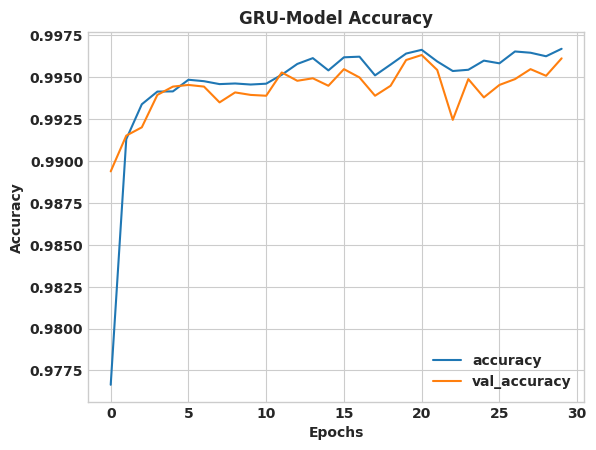

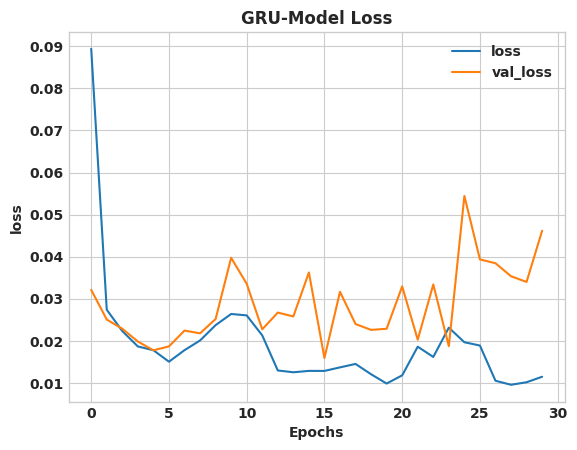

In [27]:
Acc_Loss_Graph(history)

Confusion Matrix, Without Normalization
[[ 9173     0     0     0     8]
 [    0  2336     0     0    21]
 [    0     0   196     0    28]
 [    0     0     0     0    11]
 [    8    17    21     0 13376]]


<Figure size 700x700 with 0 Axes>

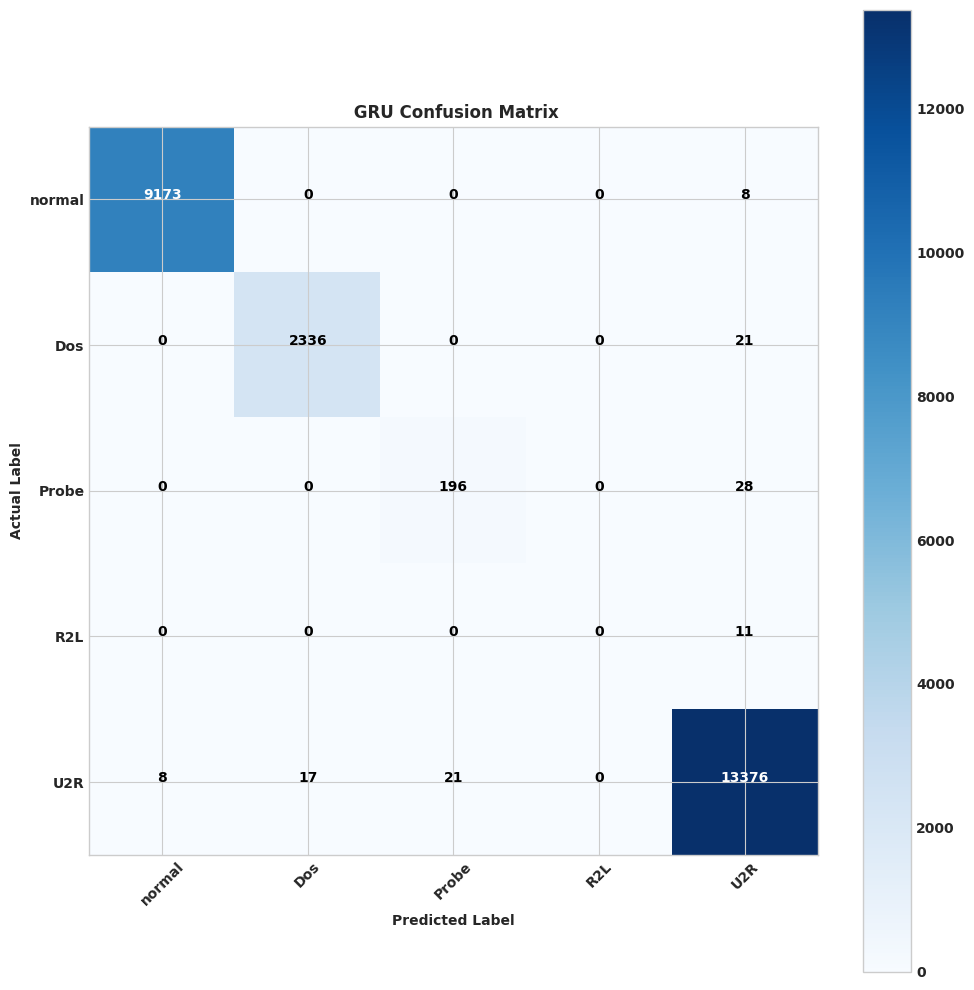

In [28]:
# Plot confusion matrix
# Calculate confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_argmax, y_pred_argmax_test)
plt.figure(figsize=(7, 7))
plot_confusion_matrix(cm=cm, classes=classes, title=' GRU Confusion Matrix')

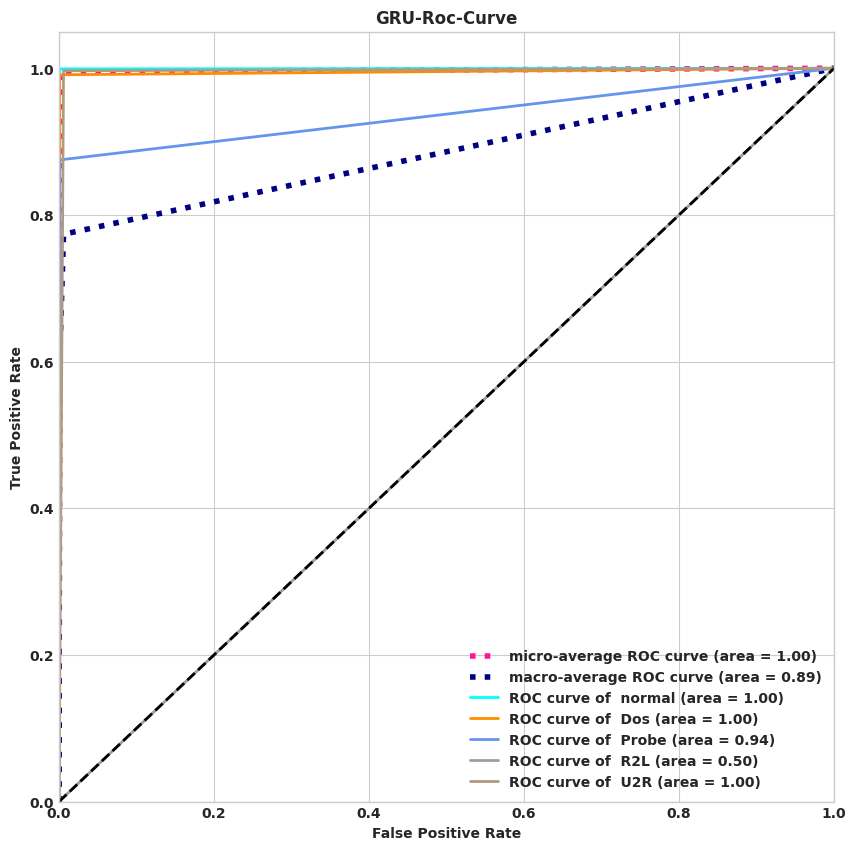

In [29]:
plot_roc_curve(y_test,y_pred_evaluation_test)

/tmp/ipykernel_26/1934223867.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['U2R' 'normal' 'normal' ... 'U2R' 'U2R' 'normal']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  cps_df.loc[:, 'target'] = cps_df.target.map(target_name)


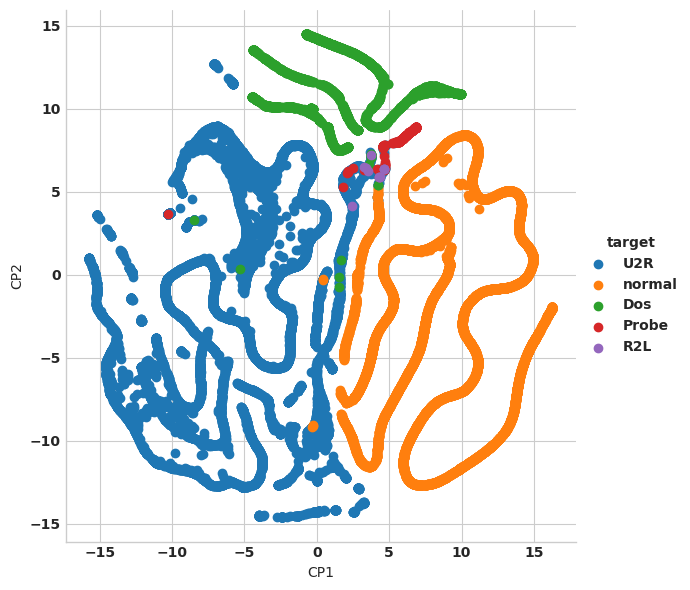

In [30]:
from sklearn.manifold import TSNE
tsne2 = TSNE(random_state = 42, n_components=2, verbose=0, perplexity=40, n_iter=300).fit_transform(y_pred_test)

# create dataframe
cps_df = pd.DataFrame(columns=['CP1', 'CP2', 'target'],
                       data=np.column_stack((tsne2, y_test_argmax)))# cast targets column to int

target_name = {0:'normal',
               1:'Dos',
               2:'Probe',
               3:'R2L',
               4:'U2R',
             }

cps_df.loc[:, 'target'] = cps_df.target.astype(int)
cps_df.loc[:, 'target'] = cps_df.target.map(target_name)

import seaborn as sns
grid = sns.FacetGrid(cps_df, hue="target", height=6)
grid.map(plt.scatter, 'CP1', 'CP2').add_legend()